In [5]:
import os
import glob
import pickle
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from PIL import Image
import pickle
import time

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

os.environ["CUDA_VISIBLE_DEVICES"]="1"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [6]:
!pip install wandb -qqq
import wandb
wandb.login()

True

In [7]:
def load_pkl(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)
X_train = load_pkl("./X_train.pkl")
X_test = load_pkl("./X_test.pkl")
y_train = load_pkl("./y_train.pkl")
y_test = load_pkl("./y_test.pkl")

# 9228 = 769 * 12. (769 tasks, 12 demos.)
# 888 = 74 * 12. (74 tasks, 12 demos.)
# 125, 125, 3:  image_size
# 768: language_size
assert X_train.shape == (769 * 12, 125, 125, 3)
assert y_train.shape == (769 * 12, 1, 768)
assert X_test.shape == (74 * 12, 125, 125, 3)
assert y_test.shape == (74 * 12, 1, 768)

X_train=X_train.astype("float")/255
X_test=X_test.astype("float")/255

In [8]:
from wandb.keras import WandbCallback

run = wandb.init(project='Convautoencoder-pretrain_128',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 300,
                     "batch_size": 32,
                     "dim": 256
                 })

config = wandb.config

/root/.pyenv/versions/3.6.8/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:
# Setting the model.
class ConvolutionalAutoencoder(Model):
    """
    layer = tf.layers.conv2d(layer, 16, 5, 2, 'same')
    layer = tf.contrib.layers.layer_norm(layer, activation_fn="elu")
    """
    def __init__(self, dim):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(125, 125, 3)),
            layers.ZeroPadding2D(padding=(3, 3)),
            layers.Conv2D(32, (4, 4), activation='elu', padding='valid', strides=1),
            layers.Conv2D(32, (4, 4), activation='elu', padding='same', strides=2),
            layers.Conv2D(64, (4, 4), activation='elu', padding='same', strides=2),
            layers.Conv2D(128, (4, 4), activation='elu', padding='same', strides=2),
            layers.Conv2D(256, (4, 4), activation='elu', padding='same', strides=2),
            layers.Flatten(),
            layers.Dense(dim)
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(8 * 8 * 256),
            layers.Reshape((8, 8, 256)),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, activation='elu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, activation='elu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=4, strides=2, activation='elu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=4, strides=2, activation='elu', padding='same'),
            layers.Conv2D(3, (4, 4), activation='sigmoid', padding='valid', strides=1)
        ])
    def call(self, x):
        # print("x_shape", x.shape)
        encoded = self.encoder(x)
        # print("encoded_shape", encoded.shape)
        decoded = self.decoder(encoded)
        # print("decoded_shape", decoded.shape)
        return decoded
autoencoder = ConvolutionalAutoencoder(config.dim)

# Setting of Model.
optimizer = tf.keras.optimizers.Adam(config.learning_rate)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    WandbCallback()
]

In [10]:
# Fit model.
autoencoder.fit(X_train, X_train, 
                epochs=config.epochs, 
                batch_size=config.batch_size, 
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=callbacks)
run.finish()

Epoch 1/200
289/289 [==============================] - 13s 29ms/step - loss: 0.0342 - val_loss: 0.0042


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/200
289/289 [==============================] - 7s 24ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 3/200
289/289 [==============================] - 7s 24ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 4/200
289/289 [==============================] - 7s 24ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/200
289/289 [==============================] - 7s 24ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/200
289/289 [==============================] - 7s 24ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/200
289/289 [==============================] - 7s 24ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/200
289/289 [==============================] - 7s 24ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/200
289/289 [==============================] - 7s 25ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/200
289/289 [==============================] - 7s 24ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/200
289/289 [==============================] - 7s 24ms/step - loss: 0.00

epoch,169
loss,0.00061
val_loss,0.00079
lr,1e-05
_runtime,1240
_timestamp,1619533621
_step,169
best_val_loss,0.00079
best_epoch,159


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [14]:
autoencoder.summary()
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "convolutional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256)               4901120   
_________________________________________________________________
sequential_1 (Sequential)    (None, 125, 125, 3)       4916995   
Total params: 9,818,115
Trainable params: 9,818,115
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 131, 131, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        16416     
___________

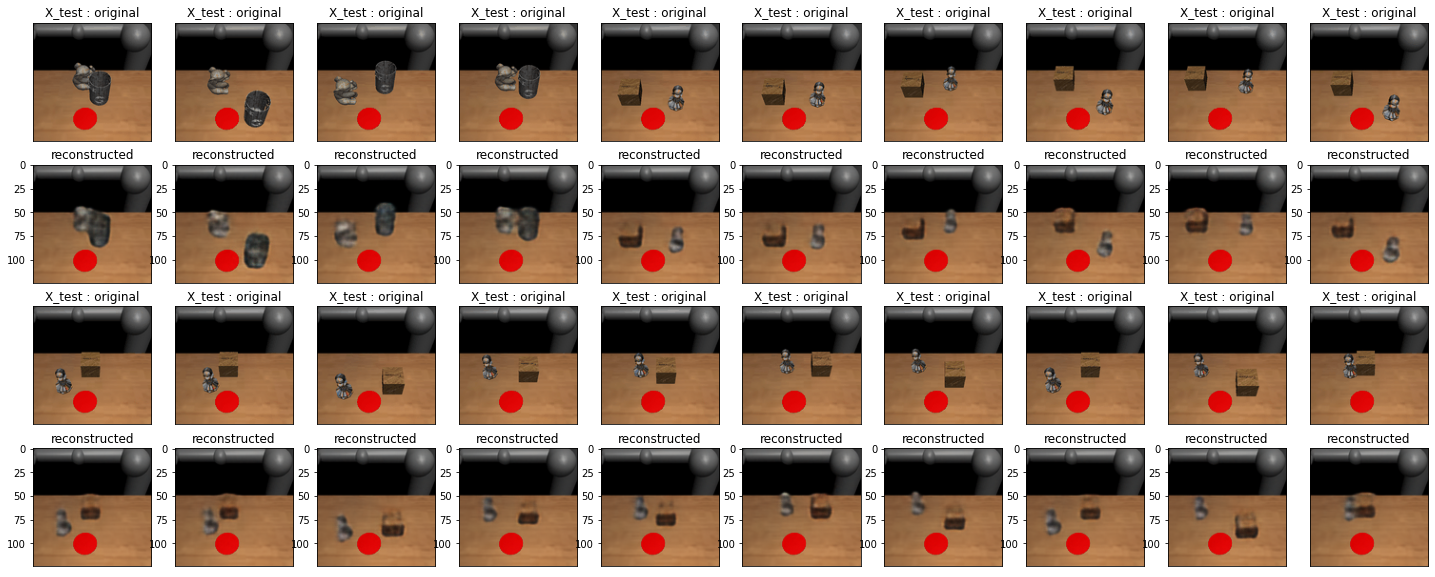

In [11]:
k = 20
encoded_imgs = autoencoder.encoder(X_test[k:k+25]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(25, 10))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(X_test[k+i])
    plt.title("X_test : original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)

        # display original
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(X_test[k + i + n])
    plt.title("X_test : original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(decoded_imgs[i + n])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    
ax.get_yaxis().set_visible(False)
plt.show()

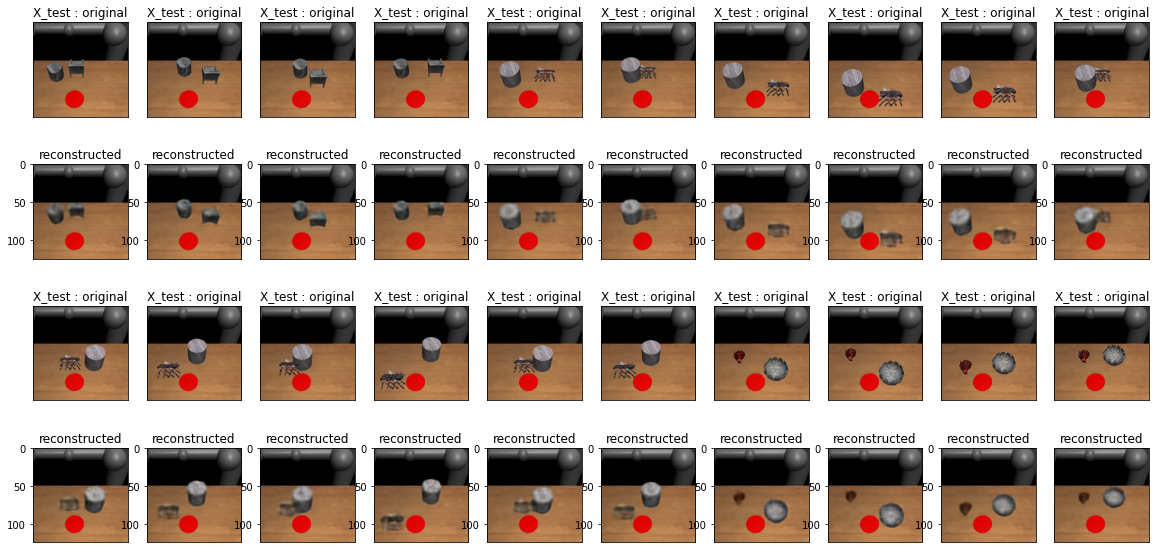

In [11]:
k = 20
encoded_imgs = autoencoder.encoder(X_train[k:k+25]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(25, 10))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(X_train[k+i])
    plt.title("X_test : original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)

        # display original
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(X_train[k + i + n])
    plt.title("X_test : original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(decoded_imgs[i + n])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    
ax.get_yaxis().set_visible(False)
plt.show()

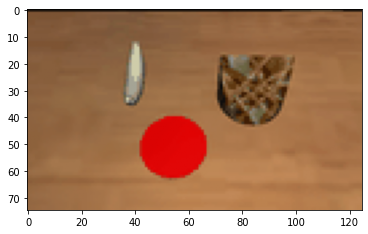

In [99]:
import cv2
# 画像の前処理
X_train.shape
rgb_img = X_train[100:110]
cut_img = rgb_img[:,50:,:,:]
plt.imshow(cut_img[9])
# print(rgb_img.shape)
# rgb_img[:,:,0]